In [1]:
import numpy as np

# Wipe all outputs from this notebook
from IPython.display import Image, clear_output, display
clear_output(True)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


# Iterative eigenspectrum calculation via the QR eigenvalue method

Here, we will learn how to iteratively calculate the eigenspectrum of large symmetric matrices using the QR eigenvalue algorithm. Note that this is a slightly overloaded term---the QR factorization can refer to both QR factorization, and the eigenvalue calculation that makes generous use of QR factorization.

Given a symmetric matrix $A$, we compute the eigenvalues and eigenvectors by performing the following calculation for many iterations. 
$$
Q_k, R_k \leftarrow \text{QR}(A_k)
$$
$$
A_{k+1} \leftarrow R_k Q_k
$$
$$
T_{k+1} \leftarrow T_k Q_k
$$
where $T_0 = \mathbb{I}$ and $A_k = Q_k R_k$ via QR factorization. After performing this iteration, the eigenvalues will sit on the diagonal of $A$, and the columns of $T_k$ will be eigenvectors.

Why does this algorithm work? For a full-rank matrix $A$, we can always find an orthonormal matrix via QR factorization using a method such as Gram-Schmidt orthonormalization. The $Q$ matrix represents the basis, and the upper-triangular $R$ matrix represents the weights necessary to project the original matrix $A$ into the orthogonal basis. Recall that the eigenvalues of a matrix are invariant to changes in basis, and so the $Q$ matrix essentially acts like a rotation (technically called the "Givens rotations"). When we perform the transformation $R Q$, we are essentially calculating $Q^{-1} A Q$ (you can use some linear algebra tricks to confirm this). This rotation eventually causes the columns of $A$ to become aligned with the eigenvectors, resulting in an upper-triangular form where we can just read the eigenvalues off the diagonal. Moreover, because a composition of rotations is still a rotation, but keeping track of the net rotation in the matrix $T_k$, we can immediately read off the eigenbasis for the system.

For a more technical description of this algorithm, as well as explicit definition of the Gram-Schmidt orthonormalization process, we refer to Chapter 11 of William Press's Numerical Recipes textbook, as well as these [lecture notes by Peter Arbenz](https://people.inf.ethz.ch/arbenz/ewp/Lnotes/chapter4.pdf)

Here, we are going to implement the QR algorithm in Python. Note that numpy, as in other languages, uses row, column format for indexing. Since we often interpret a matrix as an array of column vectors, selecting the ith column vector of a matrix `a` has the form `a[:, i]`. By convention, eigenvectors are returned in a format where the columns are eigenvectors, and so we select individual eigenvectors along the second axis.

We can break our implementation into several stages:

1. Implementing QR factorization. We can use either the Gram-Schmidt algorithm or Householder reflections to compute the QR factorization.
2. Computing an eigensystem via repeated QR factorization and transformation

## What to do next

+ Instead of using Gram-Schmidt, try implementing orthonormalization using Householder reflections
+ It's possible to generalize the QR algorithm to work for non-symmetric matrices with complex eigenvalues. However, this implementation is pretty subtle. A good discussion is provided in the [Watkins textbook](https://www.wiley.com/en-us/Fundamentals+of+Matrix+Computations%2C+3rd+Edition-p-9780470528334)

In [17]:
class QREigendecomposition:
    """
    A numpy implementation of the QR eigenvalue algorithm for symmetric matrices

    Attributes:
        eigenvalues (numpy.ndarray): The eigenvalues of the matrix.
        eigenvectors (numpy.ndarray): The eigenvectors of the matrix, stored as columns.
        store_intermediate (bool): Whether to store the intermediate matrices.
    """

    def __init__(self, store_intermediate=False):
        self.eigenvalues = None
        self.eigenvectors = None
        self.store_intermediate = store_intermediate

    def qr_factorization(self, X):
        """
        Compute the QR factorization of a square matrix using gram-schmidt 
        orthonormalization.

        Args:
            X (numpy.ndarray): A square matrix.
            
        Returns:
            Q (numpy.ndarray): An orthonormal matrix.
            R (numpy.ndarray): The upper triangular matrix.

        """
        # q, r = np.linalg.qr(X) # using numpy's built-in function
        # return q, r

        X = X.T # want first index to be the column index (for convenience)
        q, r = np.zeros(X.shape), np.zeros(X.shape) # preallocate
        q[0] = X[0] / np.linalg.norm(X[0])
        r[0] = X @ q[0]
        for i in range(1, X.shape[0]):
            q[i] = X[i] - np.sum(np.dot(X[i], q[:i].T) * q[:i].T, axis=-1)
            q[i] /= np.linalg.norm(q[i])

            ## Update the upper triangular matrix R
            r[i, i:] = X[i:] @ q[i]
        q = q.T # because we wrote into rows instead of columns
        return q, r

    def find_eigensystem(self, X, max_iter=2000, tol=1e-6):
        """
        Find the eigenvalues and eigenvectors of a matrix

        Args:
            X (numpy.ndarray): A square matrix.
            max_iter (int): The maximum number of iterations to perform.
            tol (float): The tolerance for convergence.

        Returns:
            eigenvalues (numpy.ndarray): The eigenvalues of the matrix.
        """
        prev = np.copy(X)
        qt = np.identity(X.shape[0])
        if self.store_intermediate: self.intermediate = [np.copy(X)]
        for i in range(max_iter):
            q, r = self.qr_factorization(X)
            X = r @ q
            qt = qt @ q # accumulate the eigenvector matrix

            if self.store_intermediate: self.intermediate.append(np.copy(X))

            ## Check for convergence and stop early if converged
            if np.linalg.norm(X - prev) < tol:
                break
            prev = np.copy(X)
        eigenvalues, eigenvectors = np.diag(X), qt
        sort_inds = np.argsort(eigenvalues)
        eigenvalues, eigenvectors = eigenvalues[sort_inds], eigenvectors[:, sort_inds]
        self.eigenvalues, self.eigenvectors = eigenvalues, eigenvectors
        return eigenvalues, eigenvectors

        






# Let's do a simple unit test to make sure that our class is working as expected
import unittest
class TestQR(unittest.TestCase):
    def test_factorization(self):
        """
        Test that the QR factorization is correct
        """
        np.random.seed(0)
        a = np.random.random((20, 20))
        model = QREigendecomposition()
        q, r = model.qr_factorization(a)  
        self.assertTrue(np.allclose(a, q @ r), "QR factorization failed")

    def test_eigenvalues(self):
        """
        Test that the eigenvalues are correct
        """
        np.random.seed(0)
        a = np.random.random((20, 20))
        a = a @ a.T # make sure it's symmetric
        model = QREigendecomposition()
        eigenvalues, _ = model.find_eigensystem(a)
        self.assertTrue(np.allclose(eigenvalues, np.linalg.eigh(a)[0]), "Eigenvalues are incorrect")

    def test_eigenvectors(self):
        """
        Test that the eigenvectors are correct
        """
        np.random.seed(0)
        a = np.random.random((5, 5))
        a = a @ a.T # make sure it's symmetric
        model = QREigendecomposition()
        _, eigenvectors = model.find_eigensystem(a)
        ## We have to take the absolute value of the eigenvectors because the eigenvectors
        ## are not unique up to a sign.
        self.assertTrue(
            np.allclose(np.abs(eigenvectors), np.abs(np.linalg.eigh(a)[1])), 
            "Eigenvector calculation failed"
        )

        
unittest.main(argv=[''], exit=False)



...
----------------------------------------------------------------------
Ran 3 tests in 0.045s

OK


Text(0.5, 1.0, 'Eigenvalues from numpy')

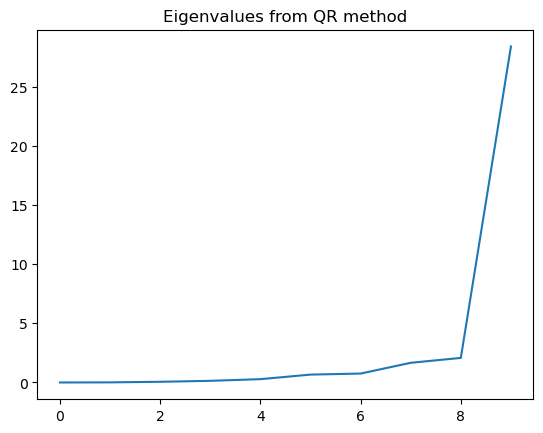

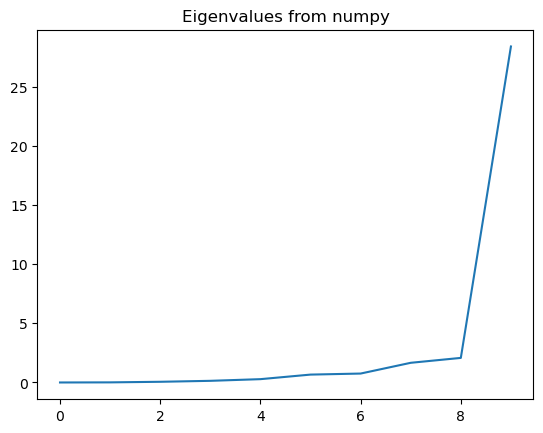

In [18]:
a = np.random.random((10, 10))
a = a @ a.T # ensure symmetric

model = QREigendecomposition(store_intermediate=True)
eigenvalues, eigenvectors = model.find_eigensystem(a)

plt.figure()
plt.plot(eigenvalues)
plt.title("Eigenvalues from QR method")

plt.figure()
plt.plot(np.linalg.eigh(a)[0])
plt.title("Eigenvalues from numpy")

In [19]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def plotter(i):
    amat = model.intermediate[i] 
    amat /= np.linalg.norm(model.intermediate[i], axis=0, keepdims=True)
    plt.figure()
    plt.plot([0, amat[:, 0][0]], [0, amat[:, 0][1]])
    plt.plot([0, amat[:, 1][0]], [0, amat[:, 1][1]])
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, 10, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=10), Output()), _d…

<function __main__.plotter(i)>

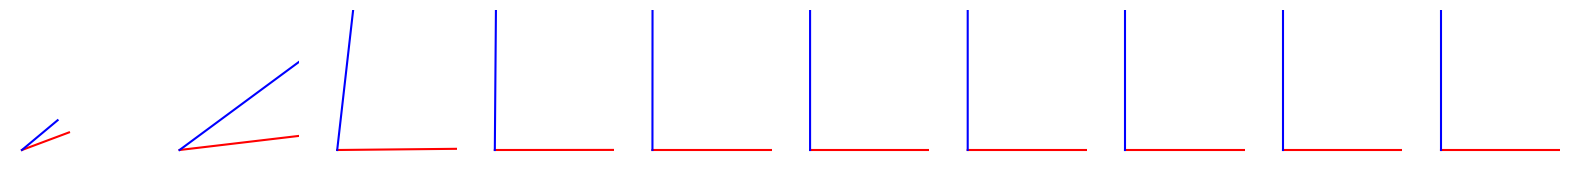

In [35]:
## Show the process of A becoming orthogonal
plt.figure(figsize=(20, 2))
for i, amat in enumerate(model.intermediate[:10]):

    vec1, vec2 = amat[:, 0], amat[:, 1]
    plt.subplot(1, 10, i+1)
    plt.plot([0, vec1[0]], [0, vec1[1]], color='red')
    plt.plot([0, vec2[0]], [0, vec2[1]], color='blue')
    plt.xlim(-0.1, 1)
    plt.ylim(-0.1, 1)
    plt.axis('off')

## Modified Gram-Schmidt decomposition

**Traditional Gram-Schmidt**
1. pick the first column vector
2. normalize it
3. pick the second column vector
4. project vector 2 onto vector 1, multiply by unit vector 1, and then subtract the resulting vector from vector 1
5. normalize vector 2
6. pick the third column vector, then project to find its components along unit vector 1 AND unit vector 2, then subtract both
7. normalize vector 3
6. rinse and repeat, subtracting the projects from all previous vectors from the current one in each step

This approach becomes unstable in high-dimensions, where the number of residual subtractions performed on a given column vector gets large. As a result, the elements of the residual vector can become very small before we apply the re-normalization step, leading to numerical errors.

In **Modified Gram-Schmidt**, we perform the steps in a different order, which allows us to re-normalize after each subtraction of a pair of vectors. 
1. pick the first column vector
2. normalize it
3. pick all remaining column vectors, and project them onto the first column vector. Subtract the projections from all of the remaining column vectors
4. pick the second column vector
5. normalize it.
6. rinse and repeat step 3

Besides the order in which we normalize and sweep, the key difference is the step where we compute projections between previously-determined unit-vectors. In the modified Gram-Schmidt, the projection occurs between the latest $i^{th}$ unit vector and a column vector $j >$ *where the previous $i - 1$ unit vectors have already been subtracted out. As a result, our dot product is less likely to be very small, because all of the $i-1$ previous shared basis vectors have already been removed by the time we compute the dot product.
+ As we saw with ill-conditioned matrices, numerical operations usually behave better when the involved vectors are further from parallel. modified GS sidesteps finding the dot product between two nearly-aligned vectors.

Text(0.5, 1.0, 'Modified Gram-Schmidt: R')

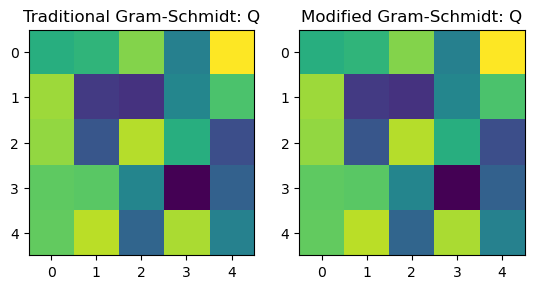

<Figure size 640x480 with 0 Axes>

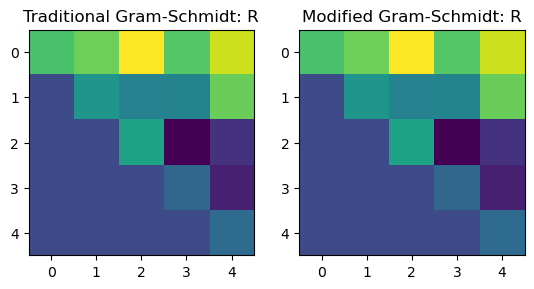

In [15]:
class QRFactorizationSolver:
    """
    Solver a linear problem using preconditioning with QR factorization. Implements both
    the traditional Gram-Schmidt process and the modified Gram-Schmidt process.
    """

    def __init__(self):
        pass

    def qr0(self, X):
        """
        Perform QR factorization using traditional Gram-Schmidt process.
        """
        self.Q = np.copy(X) # initial guess is just the original basis
        self.R = np.zeros_like(X)

        # loop over column vectors
        for i in range(X.shape[1]):

            # subtract projection of previous vectors. Notice that when i=0, this
            # loop does not run
            # We could vectorize this operation, but we leave the loop here for 
            # illustration purposes
            for j in range(i):
                self.R[j, i] = np.dot(self.Q[:, j], self.Q[:, i]) # projection weights
                self.Q[:, i] -= self.R[j, i] * self.Q[:, j] # subtract projection
            self.R[i, i] = np.linalg.norm(self.Q[:, i]) # find norm
            self.Q[:, i] /= self.R[i, i] # normalize vector
        
        return self.Q, self.R

    def qr(self, X):
        """
        Perform QR factorization using modified Gram-Schmidt process.

        In addition to the traditional advantages, this method can also be performed
        in-place on X for additional memory savings, if desired.
        """
        self.Q = np.copy(X) # initial guess is just the original basis
        self.R = np.zeros_like(X)

        # loop over columns, same as traditional Gram-Schmidt
        for i in range(X.shape[1]):

            # compute scale factor first and normalize column vector
            self.R[i, i] = np.linalg.norm(self.Q[:, i])
            self.Q[:, i] /= np.linalg.norm(self.Q[:, i])

            # loop over remaining column vectors
            for j in range(i + 1, X.shape[1]):
                self.R[i, j] = np.dot(self.Q[:, i], self.Q[:, j]) # project normalized vectors with unnormaized vectors
                self.Q[:, j] -= self.R[i, j] * self.Q[:, i] # subtract projection times existing basis
        return self.Q, self.R

    def solve(self, A, b):
        """
        Solve Ax = b using QR factorization. We can see the
        factorization as a form of preconditioning for the linear solver
        """
        Q = self.qr(A)[0]
        y = np.dot(Q.T, b)
        return np.linalg.solve(self.R, y) # O(N^2) solve because R is upper triangular
        
    def test_qr(self):
        """
        Test the QR factorization solver
        """
        a = np.random.randn(3, 3)
        q, r = self.qr(a)
        assert np.allclose(a, q @ r)

    def test_solver(self):
        A = np.random.randn(5, 5)
        b = np.random.randn(5)
        x = self.solve(A, b)
        assert np.allclose(np.dot(A, x), b)


a = np.random.random((5, 5))




plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(
    model.qr0(a)[0]
)
plt.title('Traditional Gram-Schmidt: Q')
plt.subplot(1, 2, 2)
plt.imshow(
    model.qr(a)[0]
)
plt.title('Modified Gram-Schmidt: Q')


model = QRFactorizationSolver()
plt.figure()
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(
    model.qr0(a)[1]
)
plt.title('Traditional Gram-Schmidt: R')
plt.subplot(1, 2, 2)
plt.imshow(
    model.qr(a)[1]
)
plt.title('Modified Gram-Schmidt: R')





## SVD Decomposition

+ Decompose a dataset into characteristic combinations of features (right eigenvectors) and characteristic groups of datapoints (left eigenvectors)
+ Usually used to reduce the dimensionality of a problem by truncating relevant eigenvalues; a basic compression method for high-dimensional data
+ The eigenvalue spectrum provides a clue into the dimensionality of the underlying data generating proces


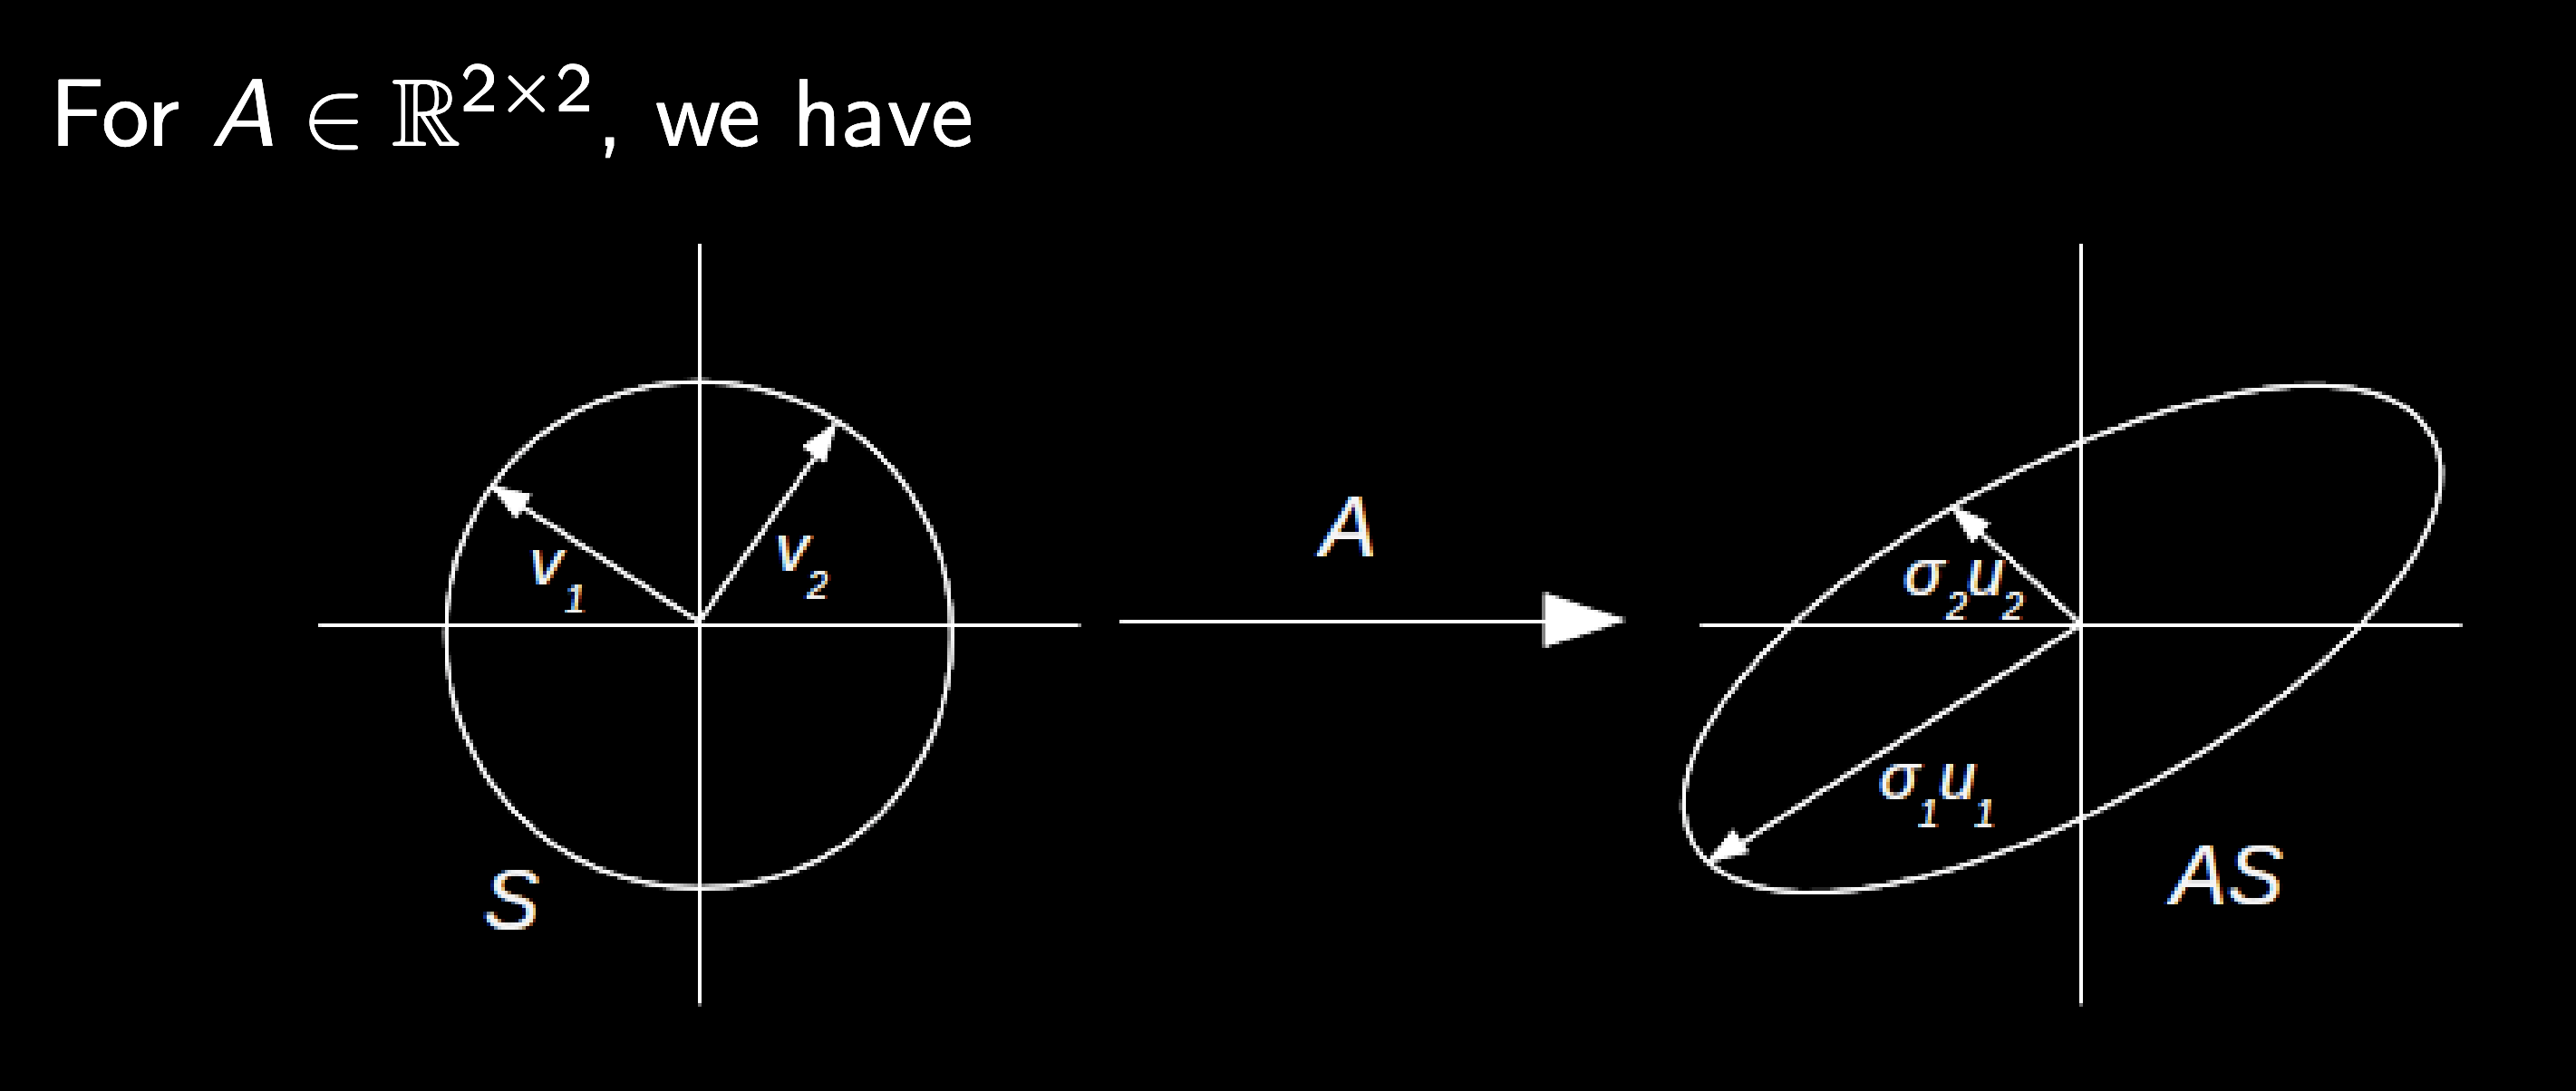

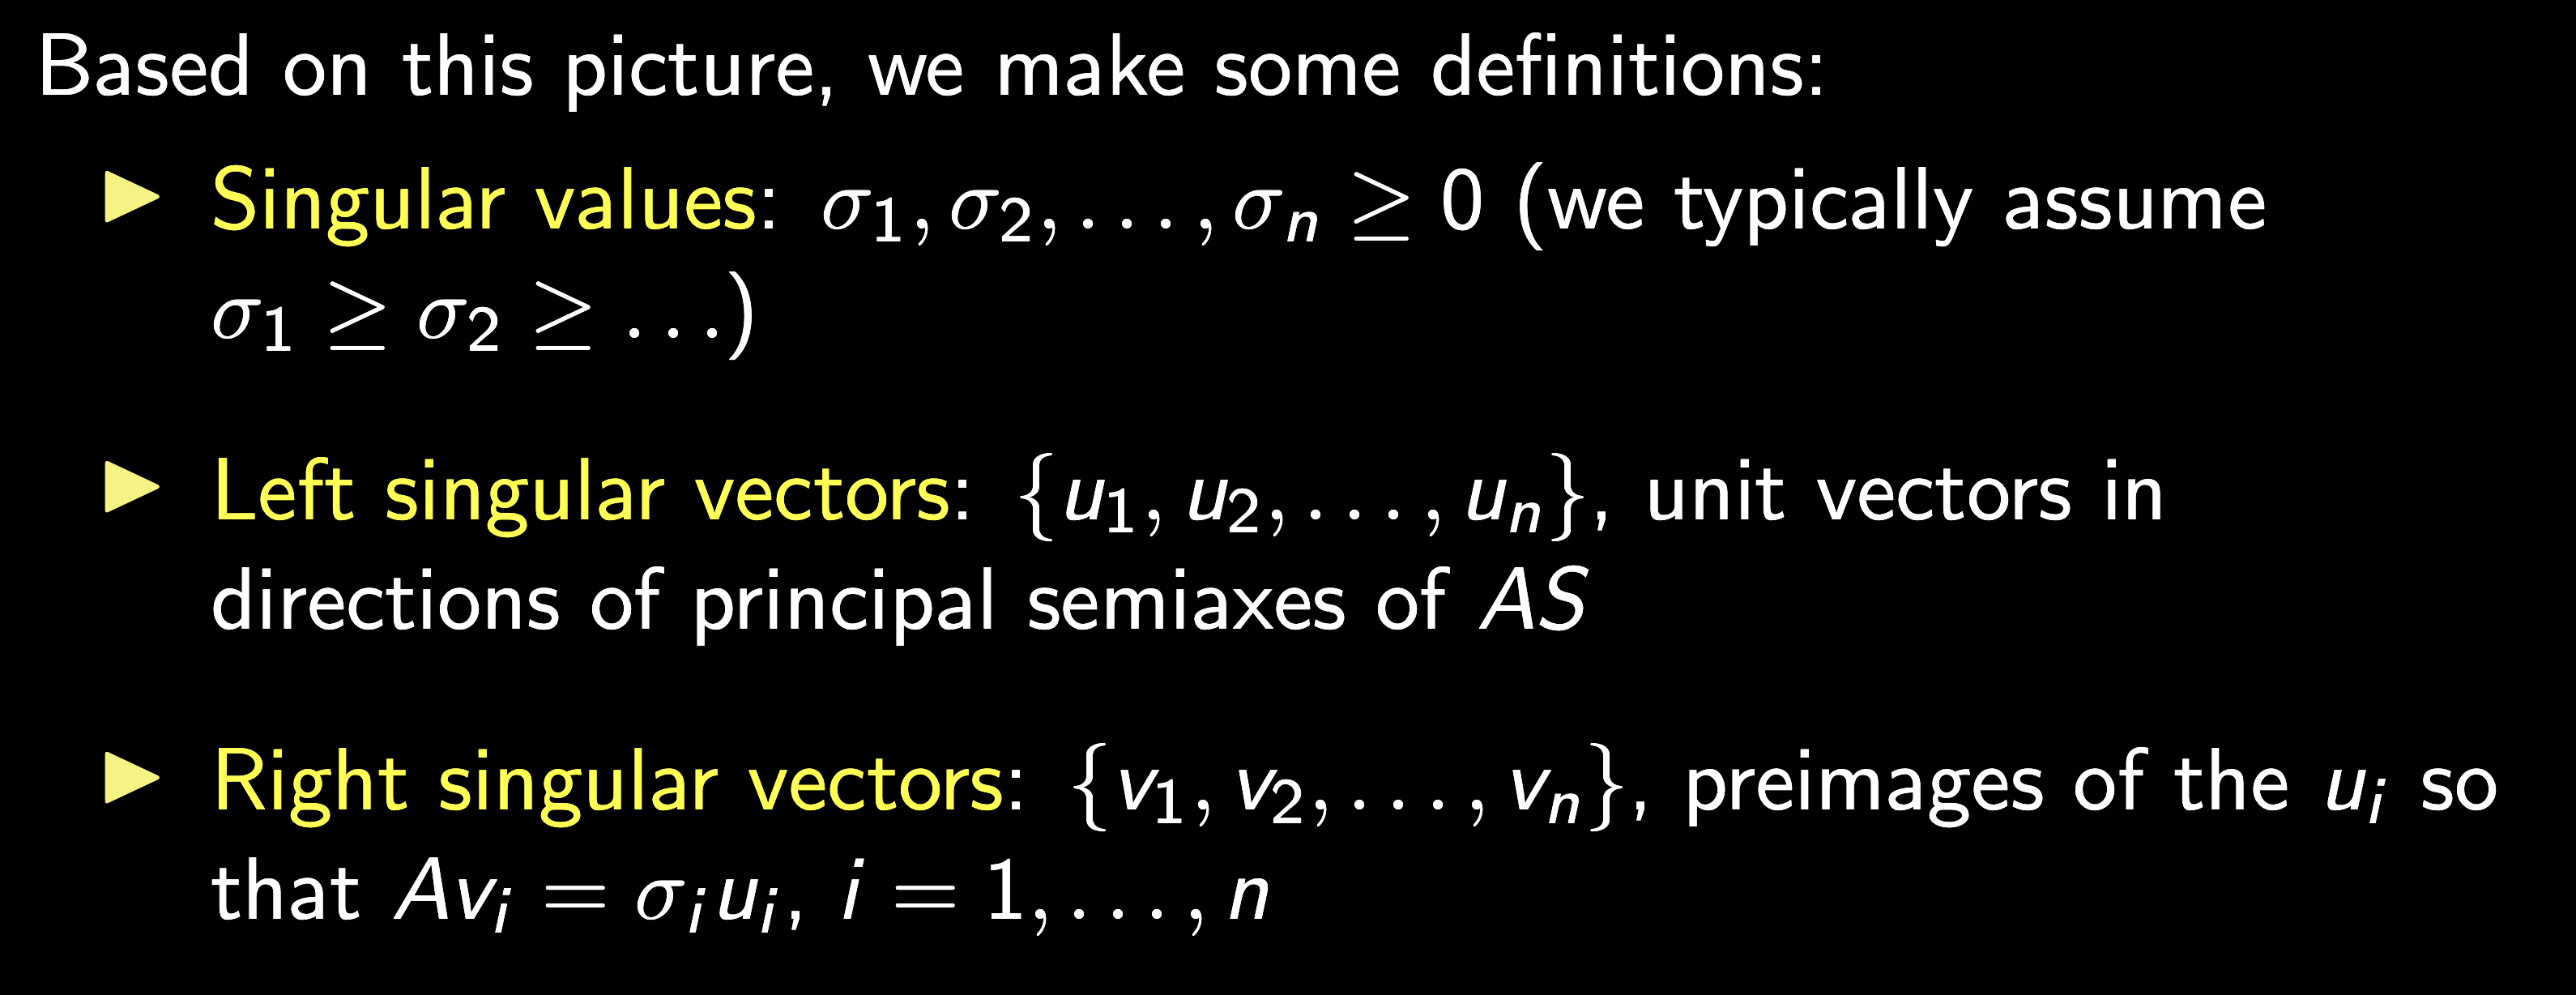

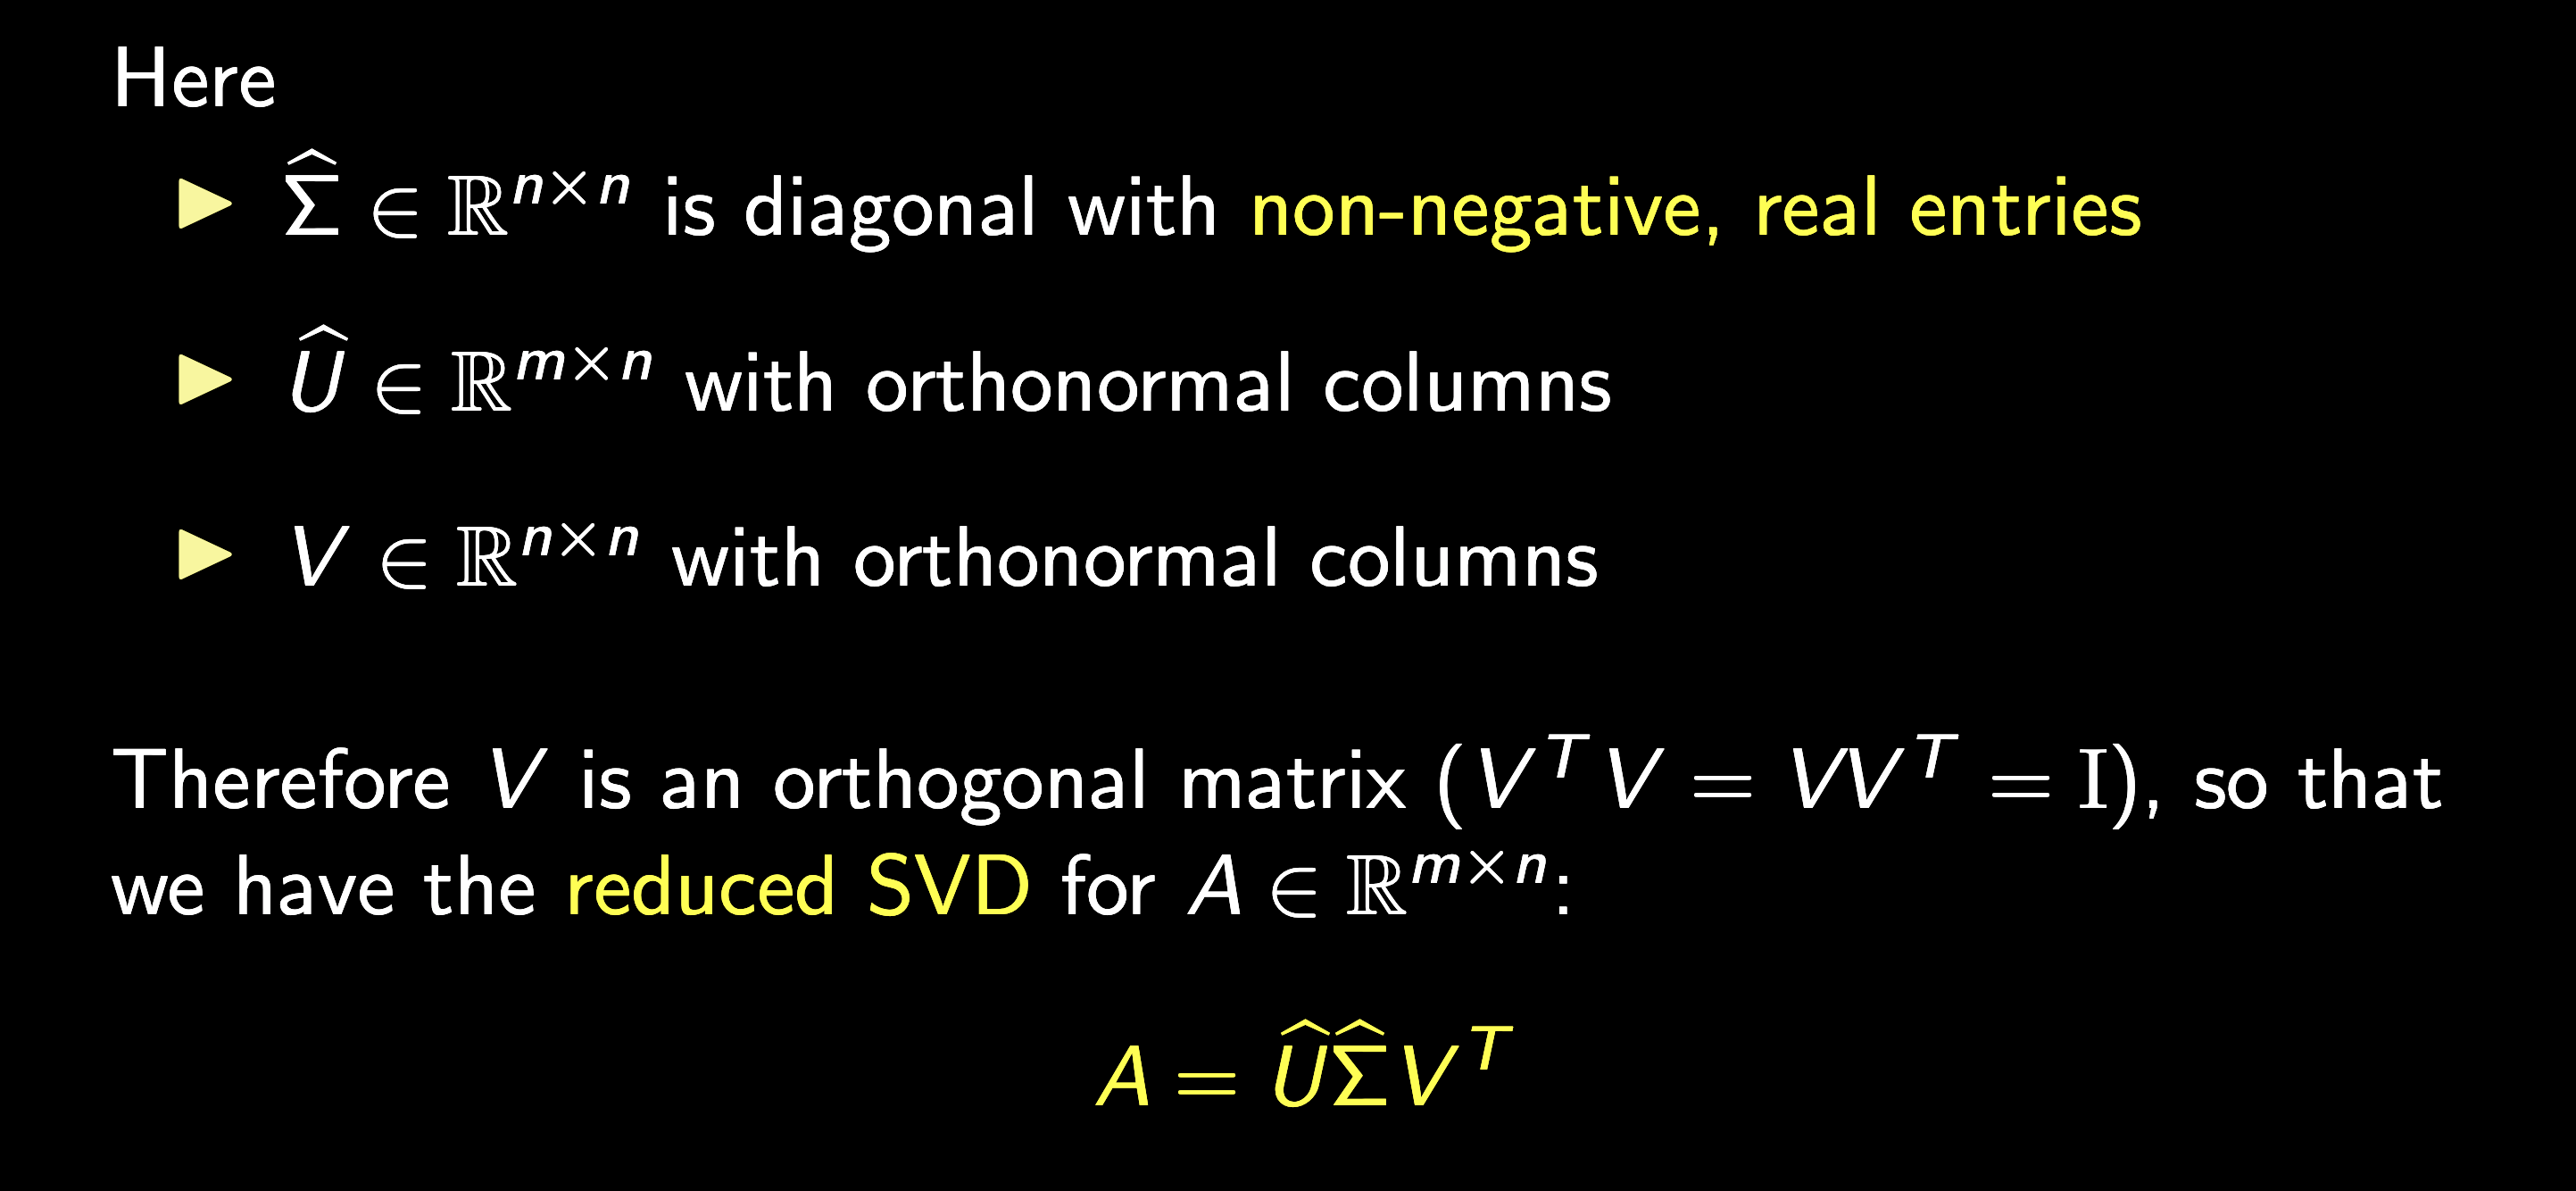

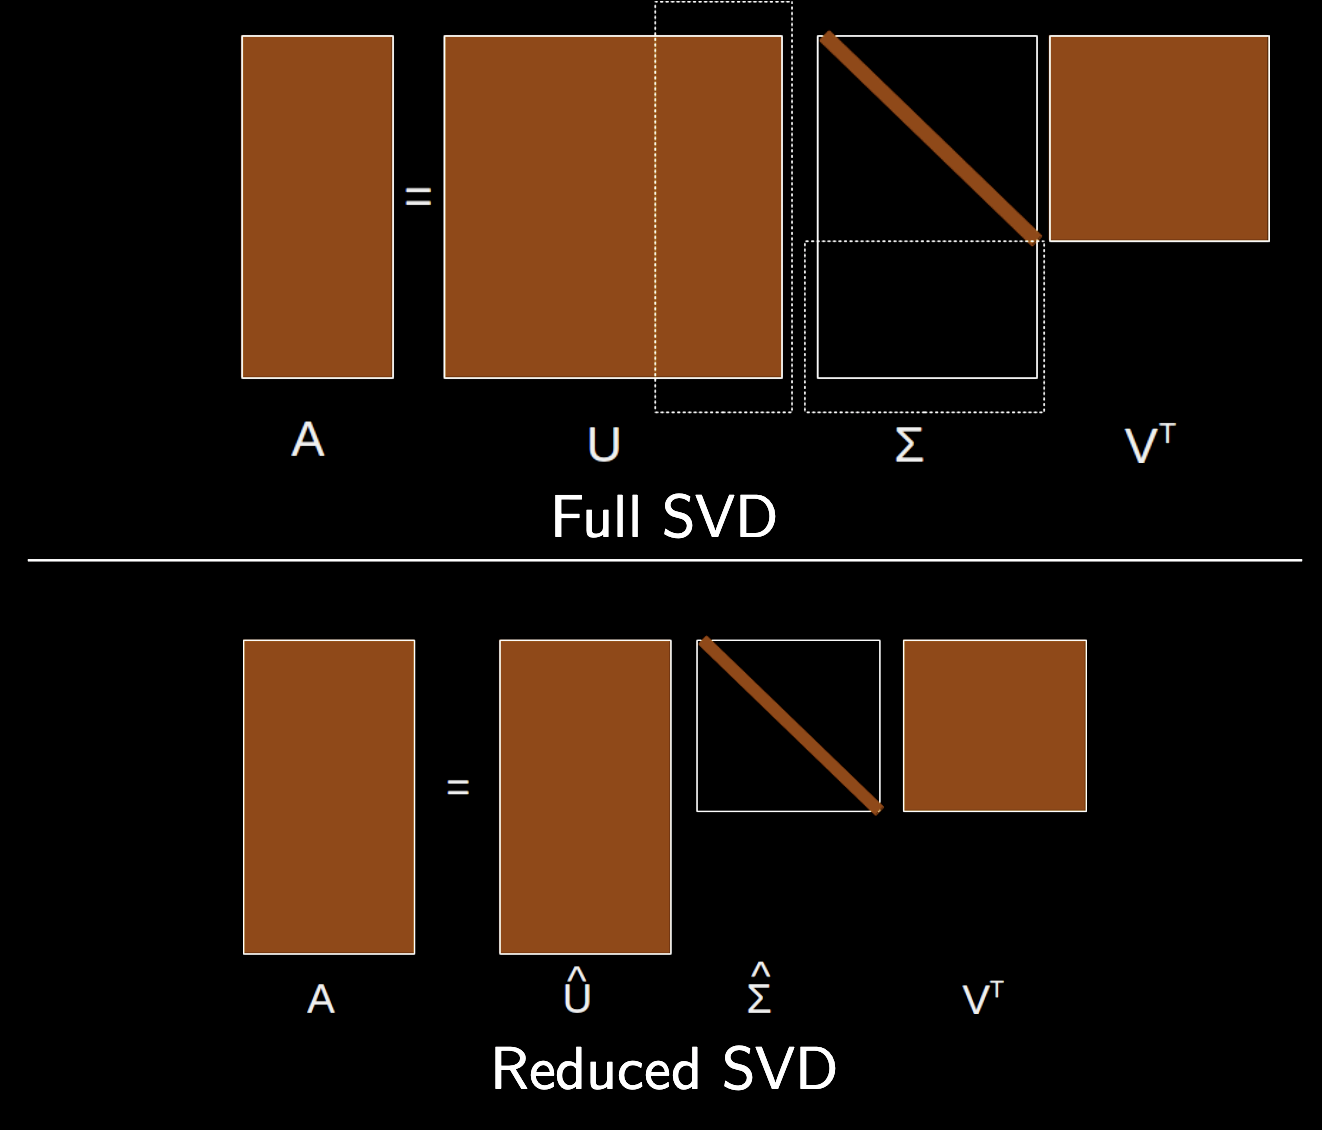

In [6]:

images = [
    Image(filename='../resources/svd_pic.png', width=800), 
    Image(filename='../resources/svd_defs.png', width=800),
    Image(filename='../resources/svd_eq.png', width=800),
    Image(filename='../resources/full_reduced_svd.png', width=800)
]
## Source: Chris Rycroft's AM205 class
display(*images)